In [9]:
import sys
from pathlib import Path
from data_utils import expand_by_genre, map_genre_ids_to_strings, drop_nan_in_column, keep_top_n_genres, \
    load_final_data_with_embeddings

BASE_DIR = Path.cwd().parent.parent
SRC_DIR = BASE_DIR / 'src'
sys.path.insert(0, str(SRC_DIR))
DATA_DIR = str(BASE_DIR / "data")

GENRE_MAP_JSON_PATH = str(SRC_DIR / "cluster_to_genre_mapping_01122025.json")

RANDOM_SEED = 42
START_YEAR = 1960
BIN_SIZE = 5
TOP_K_GENRES = 1
MAX_MOVIES_PER_YEAR = None


df = load_final_data_with_embeddings(
    csv_path=f"{DATA_DIR}/final_dataset.csv",
    data_dir=DATA_DIR
)
print(df.shape)

# Drop if genre is nan
df = drop_nan_in_column(df=df, column_name="new_genre")
print(df.shape)

# Expand the movies: if it has 2 genres then repeat it 2 times one per each genre
df = expand_by_genre(df)
print(df.shape)

# Map so instead of Genre identifiers we have the genre name
df = map_genre_ids_to_strings(df, GENRE_MAP_JSON_PATH)
print(df.shape)

# Keep top k genres because 20 genre plots are ugly
df = keep_top_n_genres(df, TOP_K_GENRES)
print(df.shape)

(92374, 39)
(79984, 39)
(122968, 39)
(122968, 39)
(31475, 40)


# Genre drift Metrics: Velocity, Acceleration and Cumulative Change

We group movies by year and genre, to analyze how each group changes it's average embedding cosine distance.

For each genre, we calculate how much the genre has changed each year compared to the previous year (drift distance) and the cumulative change over time (cumulative change).

We also calculate the acceleration, the change of the velocity over the year.




genre drama: 1930: 996
genre drama: 1935: 992
genre drama: 1940: 871
genre drama: 1945: 975
genre drama: 1950: 1238
genre drama: 1955: 1254
genre drama: 1960: 1109
genre drama: 1965: 1036
genre drama: 1970: 1210
genre drama: 1975: 1159
genre drama: 1980: 1211
genre drama: 1985: 1476
genre drama: 1990: 1518
genre drama: 1995: 1862
genre drama: 2000: 2409
genre drama: 2005: 3220
genre drama: 2010: 3338
genre drama: 2015: 3590
genre drama: 2020: 2011


Calculating drift: 100%|██████████| 19/19 [00:00<00:00, 9150.51it/s]


Drift DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   year_group          19 non-null     int64 
 1   new_genre           19 non-null     object
 2   avg_embedding       19 non-null     object
 3   group_size          19 non-null     int64 
 4   drift_velocity      19 non-null     object
 5   next_avg_embedding  18 non-null     object
 6   drift               19 non-null     object
dtypes: int64(2), object(5)
memory usage: 1.2+ KB
None



/home/martin/GroupDataLiteracy/src/analysis/stats_data.py:566: RuntimeWarning: All-NaN slice encountered
  lambda arr: np.nanmedian(arr) if isinstance(arr, np.ndarray) and arr.size > 0 else np.nan
/home/martin/anaconda3/envs/dataLiteracy/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1406: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/home/martin/anaconda3/envs/dataLiteracy/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1406: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


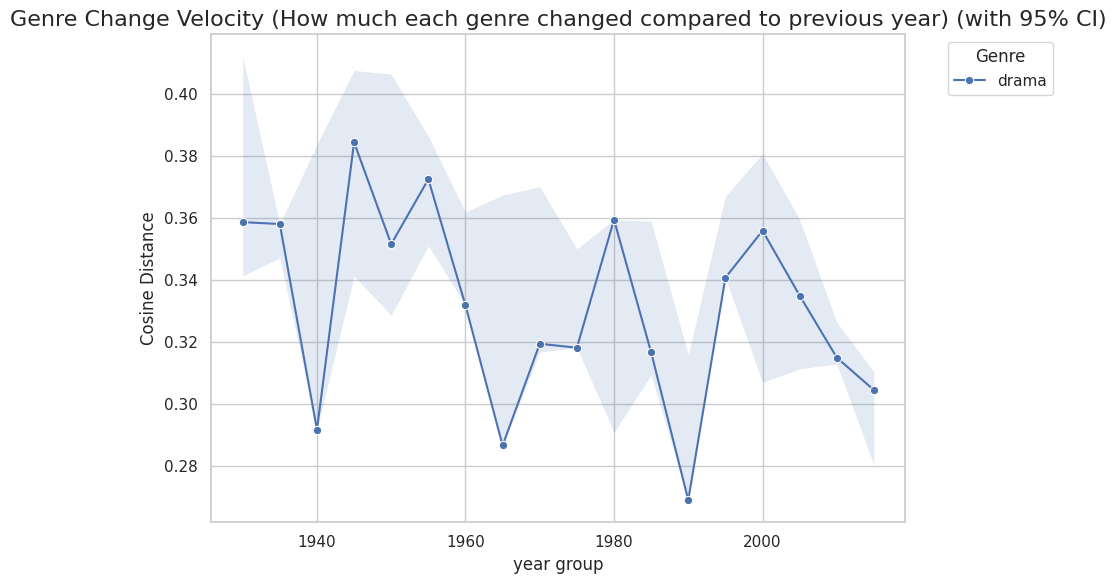

"\nplot_genre_drift(\n    df=drift_df,\n    y_column='drift_velocity_cum',\n    title='Genre Cumulative Change Over Time',\n    y_label='Cumulative Cosine Distance'\n)\nplot_genre_drift(\n    df=drift_df,\n    y_column='drift_acceleration',\n    title='Annual Change in Genre Drift (Acceleration)',\n    y_label='Acceleration (Change in Cosine Distance)',\n    softness_window=None\n)\nsoft_years = 10\nplot_genre_drift(\n    df=drift_df,\n    y_column='drift_acceleration',\n    title=f'Soft Acceleration, average over {soft_years} years',\n    y_label='Acceleration (Change in Cosine Distance)',\n    softness_window=10\n)\n"

In [10]:
from analysis.math_functions.cosine_distance_util import get_average_embedding, get_medoid_embedding
from analysis.stats_data import plot_genre_drift
from analysis.genre_drift_utils import calculate_drift_metrics

N_BOOTSTRAP_SAMPLES = 5

drift_df = calculate_drift_metrics(
    df=df,
    n_years_per_group=BIN_SIZE,
    max_movies_per_group=MAX_MOVIES_PER_YEAR,
    grouping_function=get_medoid_embedding,
    n_boostrap_samples=N_BOOTSTRAP_SAMPLES
)

print("\nDrift DataFrame Info:")
print(drift_df.info())


plot_genre_drift(
    df=drift_df,
    y_column='drift_velocity',
    title='Genre Change Velocity (How much each genre changed compared to previous year)',
    y_label='Cosine Distance'
)


"""
plot_genre_drift(
    df=drift_df,
    y_column='drift_velocity_cum',
    title='Genre Cumulative Change Over Time',
    y_label='Cumulative Cosine Distance'
)
plot_genre_drift(
    df=drift_df,
    y_column='drift_acceleration',
    title='Annual Change in Genre Drift (Acceleration)',
    y_label='Acceleration (Change in Cosine Distance)',
    softness_window=None
)
soft_years = 10
plot_genre_drift(
    df=drift_df,
    y_column='drift_acceleration',
    title=f'Soft Acceleration, average over {soft_years} years',
    y_label='Acceleration (Change in Cosine Distance)',
    softness_window=10
)
"""

# Heatmaps of genre drift

For each genre, we group the data into time bins (e.g., 5 or 10 years) and calculate the mean embedding vector for each bin. The drift distance (velocity) is then calculated as the Cosine Distance between the mean embedding vector of one time bin and the next. This distance measures how much the overall genre meaning has shifted or evolved between the two periods.

We plot heatmaps and to visualize the relationships between different time periods within each genre. Y axis is each embedding dimension, X axis is change between two time intervals. The intensity of the color represents the magnitude of the drift (Cosine Distance), showing if the genre is rapidly changing (high distance) or stable (low distance) over time. The color of the color represents the direction of the change, orange if positive, blue if negative. If two time consecutive time periods have the same color, it means that the genre is evolving in the same direction. If it has different colors, the direction has changed between those two time periods.

There are two plots per genre. The first one has the Y axis ordered according to the vector embeddings, the second one is clustered by directions which evolve in similar directions (positive / negative) so it can be interpreted easier.


In [ ]:
from analysis.stats_data import prepare_heatmap_data, plot_standard_heatmap, plot_clustermap

heatmap_matrix = prepare_heatmap_data(df=drift_df, target_genre="romance")

plot_standard_heatmap(heatmap_matrix, target_genre="romance", bin_size=BIN_SIZE)
plot_clustermap(heatmap_matrix, target_genre="romance", bin_size=BIN_SIZE)


# Inter-genre distance analysis

First plot visualizes the semantic separation between every pair of genres over time. For a single target genre (e.g., Comedy), it calculates the Cosine Distance between its average embedding vector and the vector of every other genre (e.g., Action, Drama) for each year or time bin. This results in many lines on the chart, where each line shows the changing distance between the target genre and one other genre. The plot shows if the meaning of two specific genres is getting closer (converging) or further apart (diverging) over time.

Second plot visualizes how unique or isolated each genre is compared to the rest of the film landscape over time. For a single target genre (e.g., Comedy), it first computes the average embedding vector of all the other genres combined. It then calculates the Cosine Distance between the target genre's vector and this single "mean of all others" vector for each time period. The plot shows one line per genre: if the line trends down, the genre is becoming more typical of the overall average; if it trends up, the genre is becoming more distinct.


In [ ]:
target_genres = drift_df['new_genre'].unique()
convergence_df = calculate_genre_convergence(drift_df, bin_size=5, target_genres=target_genres)
